In [83]:
bucket = 'sagemaker-demo1701'
prefix = 'sagemaker/xgboost_credit_risk'

# Define IAM role
import boto3
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer
from sklearn.metrics import roc_auc_score,accuracy_score,f1_score,roc_curve,precision_recall_curve,auc,average_precision_score
role = get_execution_role()

### Download the dataset

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls

--2019-07-17 07:10:16--  https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5539328 (5.3M) [application/x-httpd-php]
Saving to: ‘default of credit card clients.xls’

default of credit c 100%[===================>]   5.28M  2.29MB/s    in 2.3s    

2019-07-17 07:10:21 (2.29 MB/s) - ‘default of credit card clients.xls’ saved [5539328/5539328]



In [7]:
dataset = pd.read_excel('default of credit card clients.xls',index_col=0)
pd.set_option('display.max_rows', 8)
pd.set_option('display.max_columns', 15)
dataset

,X1,X2,X3,X4,X5,X6,X7,...,X18,X19,X20,X21,X22,X23,Y
ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,...,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,...,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,...,1518,1500,1000,1000,1000,5000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29997,150000,1,3,2,43,-1,-1,...,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,...,0,0,22000,4200,2000,3100,1
29999,80000,1,3,1,41,1,-1,...,85900,3409,1178,1926,52964,1804,1
30000,50000,1,2,1,46,0,0,...,2078,1800,1430,1000,1000,1000,1


In [8]:
dataset.columns

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
       'X22', 'X23', 'Y'],
      dtype='object')

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format. For this example, we use CSV. It should have the following:

- Have the predictor variable in the first column
- Not have a header row
- To format our dataset for this, we drop the “ID” column that numbers the rows in the first column and we modify the “Y” column to be the first column in our DataFrame.

In [9]:
#drop id column and label
dataset = dataset.drop('ID')
dataset = pd.concat([dataset['Y'], dataset.drop(['Y'], axis=1)], axis=1)

In [10]:
dataset.head()

,Y,X1,X2,X3,X4,X5,X6,...,X17,X18,X19,X20,X21,X22,X23
1,1,20000,2,2,1,24,2,...,0,0,689,0,0,0,0
2,1,120000,2,2,2,26,-1,...,3261,0,1000,1000,1000,0,2000
3,0,90000,2,2,2,34,0,...,15549,1518,1500,1000,1000,1000,5000
4,0,50000,2,2,1,37,0,...,29547,2000,2019,1200,1100,1069,1000
5,0,50000,1,2,1,57,-1,...,19131,2000,36681,10000,9000,689,679


### Split dataset to train,test and validate and save to S3 bucket

In [11]:
train_data, validation_data, test_data = np.split(dataset.sample(frac=1, random_state=1729), [int(0.7 * len(dataset)), int(0.9 * len(dataset))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

In [19]:
#we'll create s3_inputs that our training function can use as a pointer to the files in S3.
s3_input_train = boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_validation = boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

### Training XGB model
Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.

In [26]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

In [27]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(eta=0.1,
                        objective='binary:logistic',
                        num_round=25)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2019-07-17 08:34:16 Starting - Starting the training job...
2019-07-17 08:34:18 Starting - Launching requested ML instances......
2019-07-17 08:35:21 Starting - Preparing the instances for training......
2019-07-17 08:36:31 Downloading - Downloading input data...
2019-07-17 08:37:12 Training - Training image download completed. Training in progress.
2019-07-17 08:37:12 Uploading - Uploading generated training model
Arguments: train
[2019-07-17:08:37:07:INFO] Running standalone xgboost training.
[2019-07-17:08:37:07:INFO] File size need to be processed in the node: 2.32mb. Available memory size in the node: 8459.94mb
[2019-07-17:08:37:07:INFO] Determined delimiter of CSV input is ','
[08:37:07] S3DistributionType set as FullyReplicated
[08:37:07] 21000x23 matrix with 483000 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-07-17:08:37:07:INFO] Determined delimiter of CSV input is ','
[08:37:07] S3DistributionType set as FullyReplicated
[08:37:07] 6

### Deploy trained model

In [28]:
xgb_predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

--------------------------------------------------------------------------------------!

### Make predictions on test set


In [70]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.as_matrix()[:, 1:])
predictions

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


array([0.59283876, 0.1414548 , 0.31579986, ..., 0.41416201, 0.11323805,
       0.11232713])

In [31]:
predictions.size

3000

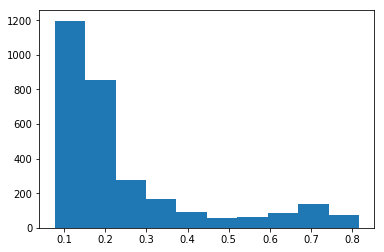

In [49]:
plt.hist(predictions)
plt.show()

### Evaluate Predictions

In [67]:
print('Confusion Matrix : ')
pd.crosstab(index=test_data.iloc[:, 0], columns=np.where(predictions > 0.25, 1, 0), rownames=['actual'], colnames=['predictions'])

Confusion Matrix : 


predictions,0,1
actual,,
0,1929,411
1,258,402


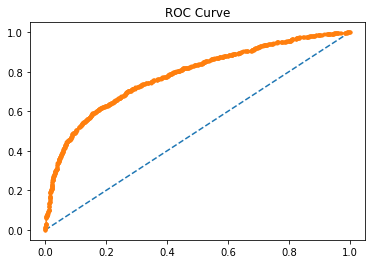

In [78]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(test_data.iloc[:, 0].astype(int), predictions)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
#set title
plt.title('ROC Curve')
# show the plot
plt.show()

In [76]:
roc_auc_score(test_data.iloc[:, 0].values.astype(int),predictions)

0.7817809505309505

f1=0.479 auc=0.555 ap=0.556


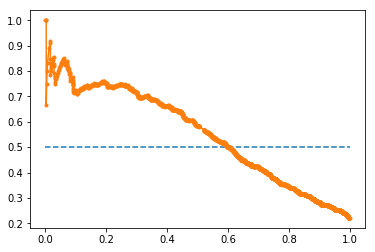

In [84]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_data.iloc[:, 0].astype(int), predictions)
# calculate F1 score
f1 = f1_score(test_data.iloc[:, 0].astype(int), np.where(predictions > 0.5, 1, 0))
# calculate precision-recall AUC
auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(test_data.iloc[:, 0].astype(int), predictions)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.')

# show the plot
plt.show()

### Relative cost of errors
Any practical binary classification problem is likely to produce a similarly sensitive cutoff. That by itself isn’t a problem. After all, if the scores for two classes are really easy to separate, the problem probably isn’t very hard to begin with and might even be solvable with simple rules instead of ML.

More important, if I put an ML model into production, there are costs associated with the model erroneously assigning false positives and false negatives. I also need to look at similar costs associated with correct predictions of true positives and true negatives. Because the choice of the cutoff affects all four of these statistics, I need to consider the relative costs to the business for each of these four outcomes for each prediction

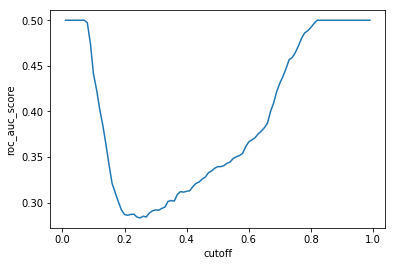

Cost is minimized near a cutoff of: 0.25 for a cost of: 0.2832750582750583


In [65]:
cutoffs = np.arange(0.01, 1, 0.01)
costs = []
for c in cutoffs:
    costs.append(1- roc_auc_score(test_data.iloc[:, 0].values.astype(int),np.where(predictions > c, 1, 0)))

costs = np.array(costs)
plt.plot(cutoffs, costs)
plt.xlabel('cutoff')
plt.ylabel('roc_auc_score')
plt.show()
print('Cost is minimized near a cutoff of:', cutoffs[np.argmin(costs)], 'for a cost of:', np.min(costs))